# Download the Data

In [1]:
!pip3 install tqdm

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/amazonei_tensorflow_p36/bin/python -m pip install --upgrade pip' command.


In [2]:
%matplotlib inline

import os
import tarfile
import urllib
import shutil
import json
import random
import numpy as np
import boto3
import sagemaker

from tqdm import tqdm
from sagemaker.amazon.amazon_estimator import get_image_uri
from matplotlib import pyplot as plt

urls = ['http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz',
        'http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz']

def download_and_extract(data_dir, download_dir):
    for url in urls:
        target_file = url.split('/')[-1]
        if target_file not in os.listdir(download_dir):
            print('Downloading', url)
            urllib.request.urlretrieve(url, os.path.join(download_dir, target_file))
            tf = tarfile.open(url.split('/')[-1])
            tf.extractall(data_dir)
        else:
            print('Already downloaded', url)

def get_annotations(file_path):
    annotations = {}
    
    with open(file_path, 'r') as f:
        rows = f.read().splitlines()

    for i, row in enumerate(rows):
        image_name, _, _, _ = row.split(' ')
        class_name = image_name.split('_')[:-1]
        class_name = '_'.join(class_name)
        image_name = image_name + '.jpg'
        annotations[image_name] = class_name
    
    return annotations, i + 1

In [3]:
if not os.path.isdir('data'):
    os.mkdir('data')

download_and_extract('data', '.')

Already downloaded http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Already downloaded http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz


In [4]:
train_annotations, _ = get_annotations('data/annotations/trainval.txt')
test_annotations, _ = get_annotations('data/annotations/test.txt')

In [5]:
all_annotations = {}

for key, value in train_annotations.items():
    all_annotations[key] = value
for key, value in test_annotations.items():
    all_annotations[key] = value

In [6]:
train_annotations = {}
test_annotations = {}

for key, value in all_annotations.items():
    if random.randint(0, 99) < 20:
        test_annotations[key] = value
    else:
        train_annotations[key] = value

In [7]:
train_count = len(list(train_annotations.keys()))
test_count = len(list(test_annotations.keys()))

print(train_count)
print(test_count)

5895
1454


# Visualize Data

In [8]:
classes = list(all_annotations.values())

classes = list(set(classes))

print(classes)
print('\nNum of classes:', len(classes))

['beagle', 'Egyptian_Mau', 'Siamese', 'Abyssinian', 'japanese_chin', 'Russian_Blue', 'leonberger', 'great_pyrenees', 'samoyed', 'wheaten_terrier', 'saint_bernard', 'pug', 'staffordshire_bull_terrier', 'keeshond', 'British_Shorthair', 'Ragdoll', 'havanese', 'Maine_Coon', 'scottish_terrier', 'Birman', 'newfoundland', 'Sphynx', 'american_pit_bull_terrier', 'basset_hound', 'english_cocker_spaniel', 'Bengal', 'boxer', 'Bombay', 'shiba_inu', 'miniature_pinscher', 'yorkshire_terrier', 'Persian', 'german_shorthaired', 'chihuahua', 'english_setter', 'american_bulldog', 'pomeranian']

Num of classes: 37


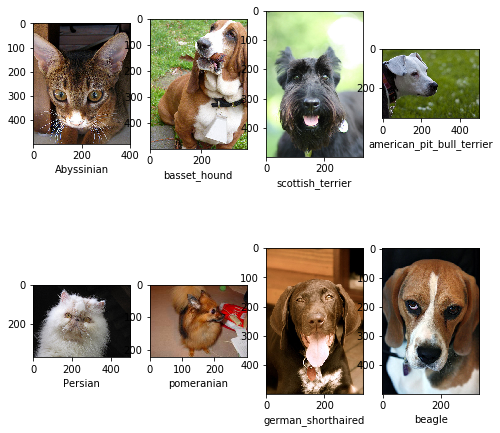

In [9]:
plt.figure(figsize=(8, 8))

train_images = list(train_annotations.keys())

for i in range(0, 8):
    plt.subplot(2, 4, i + 1)
    image = train_images[random.randint(0, train_count - 1)]
    plt.imshow(plt.imread(os.path.join('data/images/', image)))
    plt.xlabel(train_annotations[image])
plt.show()

# SageMaker Setup

In [10]:
role = sagemaker.get_execution_role()

bucket_name = 'petsdatanew'

training_image = get_image_uri(boto3.Session().region_name, 'image-classification', repo_version='latest')
print(training_image)

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


811284229777.dkr.ecr.us-east-1.amazonaws.com/image-classification:latest


In [11]:
folders = ['train', 'train_lst', 'validation', 'validation_lst']

for folder in folders:
    if os.path.isdir(folder):
        shutil.rmtree(folder)
    os.mkdir(folder)

# Preparing Data for SageMaker

In [12]:
def prepare_data(annotations, key='train'):
    images = list(annotations.keys())
    f = open(os.path.join(key + '_lst', key + '.lst'), 'w')
    with tqdm(total=len(images)) as pbar:
        for i, image in enumerate(images):
            shutil.copy(os.path.join('data/images/', image), os.path.join(key, image))
            class_id = classes.index(annotations[image])
            f.write('{}\t{}\t{}\n'.format(i, class_id, image))
            pbar.update(1)
    f.close()

In [13]:
prepare_data(train_annotations, 'train')

100%|██████████| 5895/5895 [00:10<00:00, 586.09it/s]


In [14]:
prepare_data(test_annotations, 'validation')

100%|██████████| 1454/1454 [00:02<00:00, 527.77it/s]


# Uploading Data to S3

In [15]:
sess = sagemaker.Session()

s3_train_path = sess.upload_data(path='train', bucket=bucket_name, key_prefix='train')
s3_train_lst_path = sess.upload_data(path='train_lst', bucket=bucket_name, key_prefix='train_lst')
s3_validation_path = sess.upload_data(path='validation', bucket=bucket_name, key_prefix='validation')
s3_validation_lst_path = sess.upload_data(path='validation_lst', bucket=bucket_name, key_prefix='validation_lst')

In [16]:
print(s3_train_path, s3_train_lst_path, s3_validation_path, s3_validation_lst_path)

s3://petsdatanew/train s3://petsdatanew/train_lst s3://petsdatanew/validation s3://petsdatanew/validation_lst


# SageMaker Estimator

In [17]:
model = sagemaker.estimator.Estimator(
    training_image,
    role=role,
    train_instance_count=1,
    train_instance_type='ml.p3.2xlarge',
    train_volume_size = 100,
    train_max_run = 360000,
    input_mode = 'File',
    output_path='s3://petsdatanew/output',
    sagemaker_session=sess
)

# Hyperparameters

In [18]:
model.set_hyperparameters(
    num_layers=18,
    use_pretrained_model=1,
    image_shape='3,224,224',
    num_classes=37,
    mini_batch_size=32,
    resize=224,
    epochs=10,
    learning_rate=0.001,
    num_training_samples=train_count,
    use_weighted_loss=1,
    augmentation_type='crop_color_transform',
)

# Data Channels

In [19]:
train_data = sagemaker.session.s3_input(s3_train_path, distribution='FullyReplicated', 
                                        content_type='application/x-image', s3_data_type='S3Prefix')
validation_data = sagemaker.session.s3_input(s3_validation_path, distribution='FullyReplicated',
                                             content_type='application/x-image', s3_data_type='S3Prefix')
train_lst_data = sagemaker.session.s3_input(s3_train_lst_path, distribution='FullyReplicated', 
                                        content_type='application/x-image', s3_data_type='S3Prefix')
validation_lst_data = sagemaker.session.s3_input(s3_validation_lst_path, distribution='FullyReplicated',
                                             content_type='application/x-image', s3_data_type='S3Prefix')

data_channels = {'train': train_data, 'validation': validation_data,
                'train_lst': train_lst_data, 'validation_lst': validation_lst_data}

# Model Training

In [20]:
model.fit(inputs=data_channels, logs=True)

2020-07-25 19:14:26 Starting - Starting the training job...
2020-07-25 19:14:28 Starting - Launching requested ML instances.........
2020-07-25 19:16:10 Starting - Preparing the instances for training.........
2020-07-25 19:17:28 Downloading - Downloading input data......
2020-07-25 19:18:46 Training - Downloading the training image..Docker entrypoint called with argument(s): train
[07/25/2020 19:19:09 INFO 139841145718592] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/image_classification/default-input.json: {u'beta_1': 0.9, u'gamma': 0.9, u'beta_2': 0.999, u'optimizer': u'sgd', u'use_pretrained_model': 0, u'eps': 1e-08, u'epochs': 30, u'lr_scheduler_factor': 0.1, u'num_layers': 152, u'image_shape': u'3,224,224', u'precision_dtype': u'float32', u'mini_batch_size': 32, u'weight_decay': 0.0001, u'learning_rate': 0.1, u'momentum': 0}
[07/25/2020 19:19:09 INFO 139841145718592] Merging with provided configuration from /opt/ml/input/config/hyperparameters.json: 

[07/25/2020 19:20:14 INFO 139841145718592] Epoch[2] Batch [160]#011Speed: 789.917 samples/sec#011accuracy=0.583269
[07/25/2020 19:20:14 INFO 139841145718592] Epoch[2] Batch [180]#011Speed: 794.657 samples/sec#011accuracy=0.569924
[07/25/2020 19:20:14 INFO 139841145718592] Epoch[2] Train-accuracy=0.564029
[07/25/2020 19:20:14 INFO 139841145718592] Epoch[2] Time cost=7.408
[07/25/2020 19:20:15 INFO 139841145718592] Epoch[2] Validation-accuracy=0.528533
[07/25/2020 19:20:15 INFO 139841145718592] Storing the best model with validation accuracy: 0.528533
[07/25/2020 19:20:16 INFO 139841145718592] Saved checkpoint to "/opt/ml/model/image-classification-0003.params"
[07/25/2020 19:20:16 INFO 139841145718592] Epoch[3] Batch [20]#011Speed: 743.637 samples/sec#011accuracy=0.483631
[07/25/2020 19:20:17 INFO 139841145718592] Epoch[3] Batch [40]#011Speed: 742.005 samples/sec#011accuracy=0.605183
[07/25/2020 19:20:18 INFO 139841145718592] Epoch[3] Batch [60]#011Speed: 758.568 samples/sec#011accuracy

[07/25/2020 19:20:59 INFO 139841145718592] Saved checkpoint to "/opt/ml/model/image-classification-0008.params"
[07/25/2020 19:20:59 INFO 139841145718592] Epoch[8] Batch [20]#011Speed: 819.664 samples/sec#011accuracy=0.895833
[07/25/2020 19:21:00 INFO 139841145718592] Epoch[8] Batch [40]#011Speed: 781.989 samples/sec#011accuracy=0.919970
[07/25/2020 19:21:01 INFO 139841145718592] Epoch[8] Batch [60]#011Speed: 792.915 samples/sec#011accuracy=0.921107
[07/25/2020 19:21:02 INFO 139841145718592] Epoch[8] Batch [80]#011Speed: 790.974 samples/sec#011accuracy=0.925540
[07/25/2020 19:21:03 INFO 139841145718592] Epoch[8] Batch [100]#011Speed: 786.268 samples/sec#011accuracy=0.919864
[07/25/2020 19:21:04 INFO 139841145718592] Epoch[8] Batch [120]#011Speed: 789.426 samples/sec#011accuracy=0.916322
[07/25/2020 19:21:04 INFO 139841145718592] Epoch[8] Batch [140]#011Speed: 786.498 samples/sec#011accuracy=0.916445
[07/25/2020 19:21:05 INFO 139841145718592] Epoch[8] Batch [160]#011Speed: 787.266 sampl

# Deploy Model

In [34]:
deployed_model = model.deploy(initial_instance_count = 1, instance_type = 'ml.m4.xlarge')
print('\nModel Deployed')

-----------------!
Model Deployed


# Predictions

In [35]:
image_dir = 'validation'
images = [x for x in os.listdir(image_dir) if x[-3:] == 'jpg']

deployed_model.content_type = 'image/jpeg'

In [36]:
index = 76

image_path = os.path.join(image_dir, images[index])

with open(image_path, 'rb') as f:
    b = bytearray(f.read())

results = deployed_model.predict(b)
results = json.loads(results)

print(results)

[0.07727751135826111, 2.9055652248644037e-06, 0.0003821049758698791, 6.474044766946463e-06, 0.0001800644677132368, 0.011862150393426418, 0.045945942401885986, 1.6057512766565196e-05, 0.004717010073363781, 0.03267418220639229, 0.04762930050492287, 0.00017121023847721517, 0.36534416675567627, 6.437931733671576e-05, 0.00010621554974932224, 2.0742307242471725e-05, 0.0009711174061521888, 6.0382528317859396e-05, 0.00024545873748138547, 4.938033271173481e-06, 0.18049989640712738, 0.0005854392657056451, 0.0366298146545887, 0.022006411105394363, 0.12230303883552551, 3.287019865183538e-07, 0.0012386648450046778, 1.0109677532454953e-05, 0.00011584310414036736, 0.0011273123091086745, 0.00014537743118125945, 1.0081382242788095e-05, 0.015602899715304375, 3.798224133788608e-05, 0.021486345678567886, 0.010499740950763226, 1.8384045688435435e-05]


In [37]:
classes[np.argmax(results)]

'staffordshire_bull_terrier'

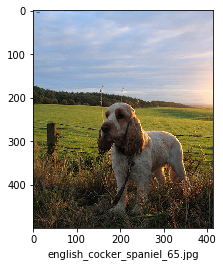

In [38]:
plt.imshow(plt.imread(image_path))
plt.xlabel(images[index])
plt.show()

Enter the image number: 876


Predicted Class: Egyptian_Mau

 Actual Image


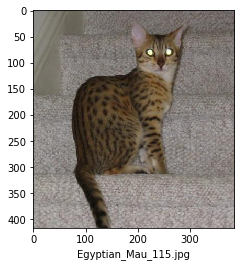

In [54]:
index = int(input("Enter the image number: "))

image_path = os.path.join(image_dir, images[index])

with open(image_path, 'rb') as f:
    b = bytearray(f.read())

results = deployed_model.predict(b)
results = json.loads(results)

#print(results)

print('\n')
print("Predicted Class:", classes[np.argmax(results)])

print('\n Actual Image')
plt.imshow(plt.imread(image_path))
plt.xlabel(images[index])
plt.show()

# Delete endpoint

In [32]:
sagemaker.Session().delete_endpoint(deployed_model.endpoint)